1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_name = "data_000637.txt"
data = pd.read_csv(file_name)
print(data)

dt=pd.read_csv(file_name, nrows = 30000)
print(dt)

         HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0           1     0          123  3869200167        2374        26
1           1     0          124  3869200167        2374        27
2           1     0           63  3869200167        2553        28
3           1     0           64  3869200167        2558        19
4           1     0           64  3869200167        2760        25
...       ...   ...          ...         ...         ...       ...
1310715     1     0           62  3869211171         762        14
1310716     1     1            4  3869211171         763        11
1310717     1     0           64  3869211171         764         0
1310718     1     0          139  3869211171         769         0
1310719     1     0           61  3869211171         762        18

[1310720 rows x 6 columns]
       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0         1     0          123  3869200167        2374        26
1         1     0          124  386920

2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [2]:
max_orbit = dt.groupby('ORBIT_CNT')['BX_COUNTER'].max()

diff = max_orbit.diff().dropna()

x = int(diff.values[0])
print("Value x (amount of BX_COUNTER in one ORBIT_CNT):", x)

Value x (amount of BX_COUNTER in one ORBIT_CNT): 351


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

*Hint:* introduce an offset to the absolute time such that the start of the data acquisition (i.e. the first entry) is zero.

In [4]:
dt['Absolute_Time_in_ns'] = dt['ORBIT_CNT'] * (dt['BX_COUNTER'] * 25 + dt['TDC_MEAS'] * (25/30))

dt['Absolute_Time_in_ns'] = pd.to_datetime(dt['Absolute_Time_in_ns'], unit='ns')
print(dt)

       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
0         1     0          123  3869200167        2374        26   
1         1     0          124  3869200167        2374        27   
2         1     0           63  3869200167        2553        28   
3         1     0           64  3869200167        2558        19   
4         1     0           64  3869200167        2760        25   
...     ...   ...          ...         ...         ...       ...   
29995     1     1           60  3869200466         356        11   
29996     1     0           64  3869200466         347         4   
29997     1     0          139  3869200466         357         0   
29998     1     0           61  3869200466         353        10   
29999     1     0          119  3869200466         357         5   

                Absolute_Time_in_ns  
0     1970-01-03 15:48:40.862581735  
1     1970-01-03 15:48:44.086915207  
2     1970-01-03 20:37:21.981996005  
3     1970-01-03 20:44:56.61301

4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [5]:
duration = dt['Absolute_Time_in_ns'].max() - dt['Absolute_Time_in_ns'].min()

hours = duration.components.hours
minutes = duration.components.minutes
seconds = duration.components.seconds

print("Duration of the data taking is", hours, "hours", minutes, "minutes", seconds, "seconds")

Duration of the data taking is 23 hours 45 minutes 42 seconds


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [6]:
noisy_channels = dt.groupby('TDC_CHANNEL').count()["FPGA"].nlargest(3)

for channel, count in noisy_channels.items():
    print("Channel", channel, ":", count, "events" )

Channel 139 : 2503 events
Channel 64 : 1518 events
Channel 63 : 1481 events


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [7]:
nonempty_orbits = dt['ORBIT_CNT'].nunique()
print('Number of non-empty orbits', nonempty_orbits)

Number of non-empty orbits 300


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [13]:
data_channel = dt[dt['TDC_CHANNEL'] == 139]
unique_orbits_amount = data_channel['ORBIT_CNT'].nunique()
print('Number of unique orbits in 139 channel :', unique_orbits_amount)

Number of unique orbits in 139 channel : 300


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [14]:
fpga1 = dt[dt['FPGA']==1].value_counts('TDC_CHANNEL')
fpga0 = dt[dt['FPGA']==0].value_counts('TDC_CHANNEL')
print("FPGA 1 Series:\n", fpga1)
print("FPGA 1 Series:\n", fpga0)

FPGA 1 Series:
 TDC_CHANNEL
139    748
2      721
1      649
4      588
3      533
      ... 
84       2
91       1
82       1
78       1
86       1
Name: count, Length: 126, dtype: int64
FPGA 1 Series:
 TDC_CHANNEL
139    1755
64     1482
63     1463
61     1112
62     1063
       ... 
104      11
109      11
106      11
101       4
67        3
Name: count, Length: 118, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

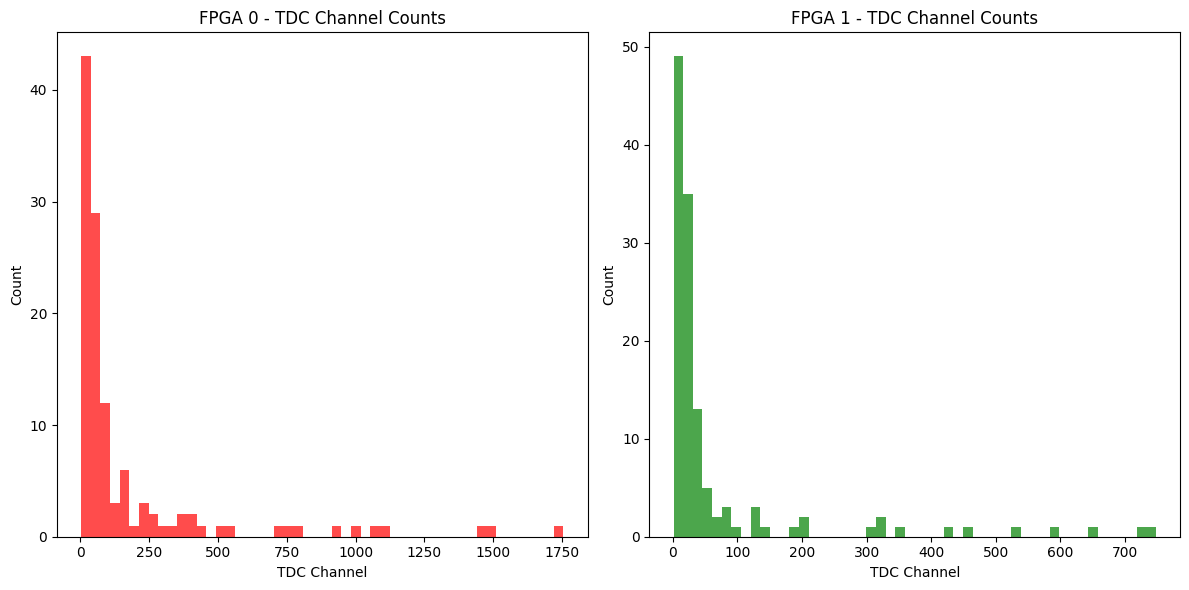

In [15]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(fpga0, bins=50, color='red', alpha=0.7)
plt.title('FPGA 0 - TDC Channel Counts')
plt.xlabel('TDC Channel')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(fpga1, bins=50, color='green', alpha=0.7)
plt.title('FPGA 1 - TDC Channel Counts')
plt.xlabel('TDC Channel')
plt.ylabel('Count')

plt.tight_layout()
plt.show()